# torchdyn Tutorials

In [2]:
from torchdyn.core import NeuralODE
from torchdyn.nn import DataControl, DepthCat, Augmenter, GalLinear, Fourier
from torchdyn.datasets import *
from torchdyn.utils import *

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import torch

import xarray as xr

c:\Users\Anwender\.conda\envs\rivapy\lib\site-packages\gribapi\__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(


[[[ 9.205143    9.112887    9.071489   ...  8.364402    7.984094
    7.642229  ]
  [ 9.517444    9.3882265   9.28428    ...  8.300476    7.906915
    7.5389247 ]
  [ 9.965678    9.812309    9.615565   ...  8.110103    7.6562715
    7.1694245 ]
  ...
  [ 3.3602154   3.2731552   3.2686858  ...  1.0407048   0.84154177
    0.5539943 ]
  [ 3.257956    3.200339    3.0236487  ...  0.8951459   1.0790251
    1.0779116 ]
  [ 2.8235126   2.6269243   2.3865619  ...  0.7247255   1.0399975
    1.3415747 ]]

 [[10.54115    10.304861   10.014737   ...  8.702614    8.242794
    7.7938924 ]
  [11.04068    10.861573   10.501436   ...  8.81585     8.343879
    7.826096  ]
  [11.607791   11.535241   11.165502   ...  8.643271    8.1434145
    7.5359173 ]
  ...
  [ 3.523604    3.3420477   3.2509992  ...  1.0682285   0.84648895
    0.5592244 ]
  [ 3.4119747   3.248493    3.0030239  ...  0.9144973   1.1182313
    1.0937926 ]
  [ 2.946015    2.7070587   2.4436555  ...  0.6619326   1.061256
    1.3866563 ]]

 [[

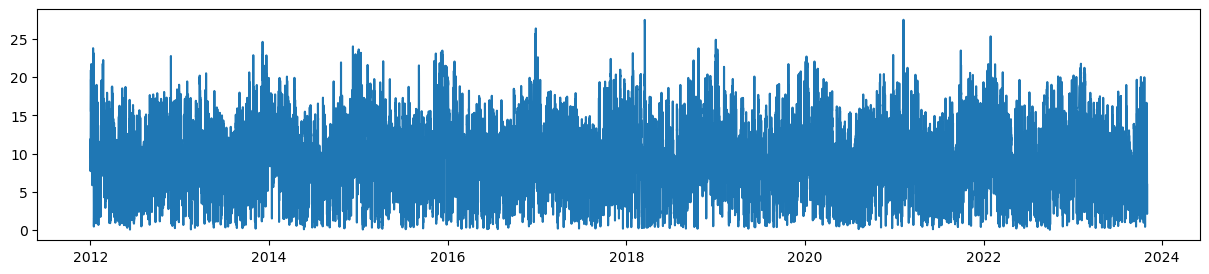

In [3]:
f = xr.open_dataset('dataset_2012-2023_1000hPa.nc')



lons = f.variables['longitude'][:]  # longitude
lats = f.variables['latitude'][:]  # latitude
u100 = f.variables['u'][:,:,:,0] # u-wind at 100m height
v100 = f.variables['v'][:,:,:,0]  # v-wind at 100m height
time = f.variables['time'][:]


ws100_data = np.array(np.sqrt(u100*u100+v100*v100))


nan_idx = np.argwhere(~np.isnan(ws100_data[:,0,0])).T[0]
ws100 = ws100_data[nan_idx,:,:]
time_vec = time[nan_idx]

plt.figure(figsize = (15,3))
plt.plot(time_vec, ws100[:,2,2])

print(ws100)


[[5.06642717e+02 1.75157678e-06]
 [1.75157678e-06 2.57537774e+02]]


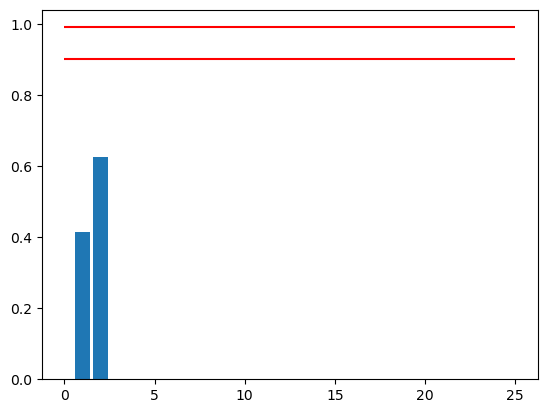

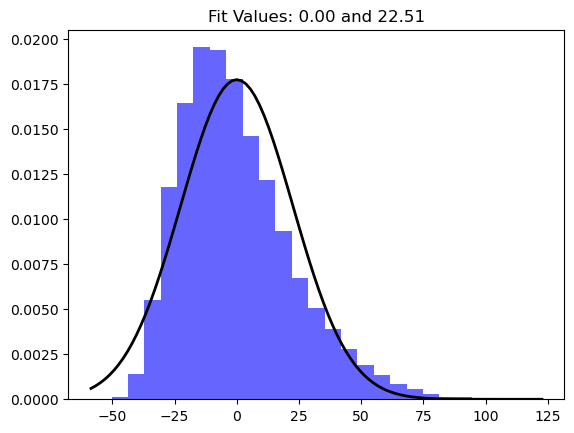

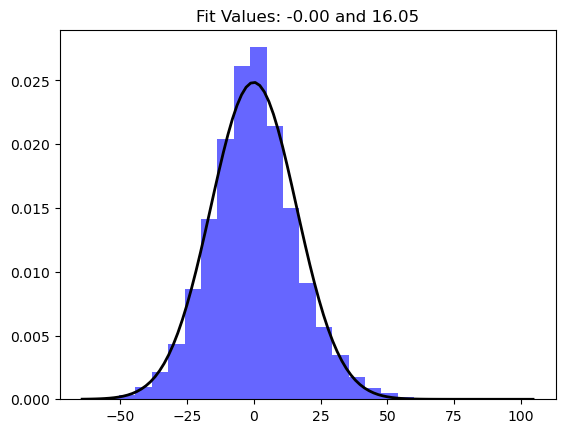

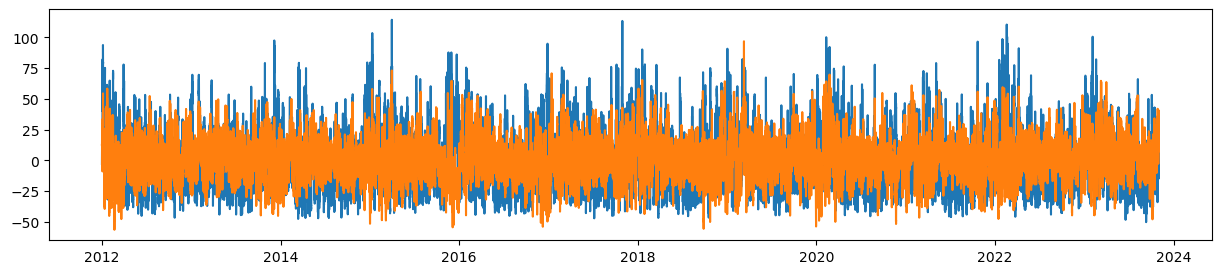

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import pandas as pd
from scipy.stats import norm 


nPCAc = 2
ws100[np.isnan(ws100)] = 0
Y = ws100[:,:,:]
X = Y.reshape(Y.shape[0], -1)
scaler = StandardScaler(with_mean=True, with_std=True)
X = scaler.fit_transform(X)
pca = PCA(n_components=nPCAc)
principalComponents_ERA5 = pca.fit_transform(X)

bla = principalComponents_ERA5[:150000,0]
for j in range(1,nPCAc):
    bla = np.vstack([bla, principalComponents_ERA5[:150000,j]])       
sigq = np.cov(bla)

print(sigq)


plt.figure(1)
plt.bar(np.linspace(1,pca.n_components_,pca.n_components_), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(y = 0.9,xmin= 0, xmax = 25,colors="red")
plt.hlines(y = 0.99,xmin= 0, xmax = 25,colors="red")
plt.show()

for i in range(nPCAc):

    #plt.figure(i+2, figsize=[15,3])
    #plt.plot(principalComponents_ERA5[:150000,i])

    mu, std = norm.fit(principalComponents_ERA5[:150000,i]) 
    plt.figure(i+2)
    plt.hist(principalComponents_ERA5[:150000,i], bins=25, density=True, alpha=0.6, color='b') 
    xmin, xmax = plt.xlim() 
    x = np.linspace(xmin, xmax, 100) 
    p = norm.pdf(x, mu, std) 
  
    plt.plot(x, p, 'k', linewidth=2) 
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std) 
    plt.title(title) 

plt.figure(figsize=[15,3])
plt.plot(time_vec,principalComponents_ERA5[:150000,0])
plt.plot(time_vec,principalComponents_ERA5[:150000,1])

# Neural ODE last year

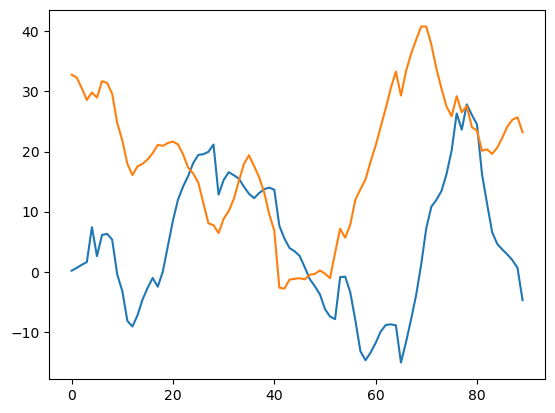

In [227]:
X = principalComponents_ERA5[-91:-1,:]
yn = np.array(range(0,len(X[:,0]),1))

plt.plot(yn,X[:,0])
plt.plot(yn,X[:,1])




In [228]:
from torchdyn.core import NeuralODE, ODEProblem
from torchdyn.nn import DataControl, DepthCat, Augmenter
from torchdyn.datasets import *
from torchdyn.utils import *
import torch
import torch.nn as nn

In [229]:
# quick run for automated notebook validation
dry_run = False

In [230]:
# Vanilla Version of stable neural flows
class Stable(nn.Module):
    """Stable Neural Flow"""
    def __init__(self, net, depthvar=False, controlled=False):
        super().__init__()
        self.net, self.depthvar, self.controlled = net, depthvar, controlled
        
    def forward(self, x):
        with torch.set_grad_enabled(True):
            bs, n = x.shape[0], x.shape[1] // 2
            x = x.requires_grad_(True)
            eps = self.net(x).sum()
            out = -torch.autograd.grad(eps, x, allow_unused=False, create_graph=True)[0] 
        out = out[:,:-1] if self.depthvar else out
        out = out[:,:-2] if self.controlled else out
        return out

In [231]:
# Conservative variant of stable neural flow
class ConservativeStable(nn.Module):
    """Conservative Stable Neural Flow"""
    def __init__(self, net, depthvar=False, controlled=False):
        super().__init__()
        self.net, self.depthvar, self.controlled = net, depthvar, controlled
        self.M = torch.nn.Parameter(torch.randn(2,2)).to(device)
    
    # impose the system matrix to be skew symmetric
    def Skew(self):
        return .5*(self.M - self.M.T)

    def forward(self, x):
        with torch.set_grad_enabled(True):
            bs, n = x.shape[0], x.shape[1] // 2
            x = x.requires_grad_(True)
            eps = self.net(x).sum()
            out = -torch.autograd.grad(eps, x, allow_unused=False, create_graph=True)[0] 
            #self.out = out
        out = out[:,:-1] if self.depthvar else out
        out = out[:,:-2] if self.controlled else out
        return out @ self.Skew()

In [243]:
X_tensor = torch.tensor(X)
X_np = np.array(X)
X_ten =  torch.tensor(X_np)


dx = torch.diff(X_ten[:,0])
dy = torch.diff(X_ten[:,1])


<function matplotlib.pyplot.show(close=None, block=None)>

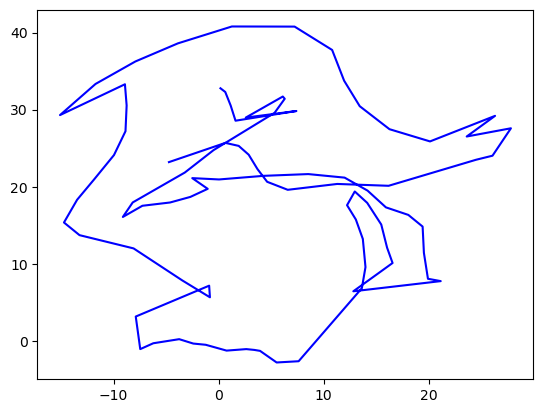

In [273]:

plt.plot(X_ten[:,0], X_ten[:,1], color='blue')#, alpha=.1)
plt.show


In [260]:
# We use this class to simulate through torchdyn the above nonlinear system
class odefunc(nn.Module):
    def __init__(self, sys):
        super().__init__()
        self.sys = sys
    def forward(self, x):
        return self.sys(x)
## nonlinear conservative vector field   
def sys(x):
    dxdt =  dx 
    dydt =  dy
    return torch.cat([dxdt[:,None], dydt[:,None]], 1)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
Your vector field does not have `nn.Parameters` to optimize.


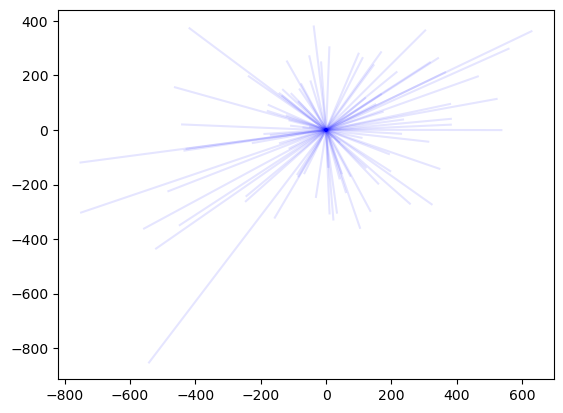

In [270]:
# define the system model just like a neural ODE
system = ODEProblem(odefunc(sys), solver='dopri5')
x0, t_span = torch.randn(89,2), torch.linspace(0, 90, 90)
# simulate the system
_, traj = system(x0, t_span)

# plot the trajectories
for i in range(len(x0)):
    plt.plot(traj[:,i,0], traj[:,i,1], color='blue', alpha=.1)

In [1]:
import torch.utils.data as data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Data
vf = odefunc(sys)
X = torch.rand(89,2).to(device)
y = vf(X)
train = data.TensorDataset(X, y)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=False)

NameError: name 'torch' is not defined

In [263]:
import pytorch_lightning as pl
import copy
        
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        return self.model.defunc(0,x)
    
    def loss(self, y, y_hat):
        return ((y-y_hat)**2).sum(1).mean()
    
    def training_step(self, batch, batch_idx):
        x = torch.randn(89,2).to(device)
        y = vf(x)
        y_hat = self.model.vf(0,x)   
        loss = self.loss(y_hat, y)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

    def train_dataloader(self):
        return trainloader

In [264]:
# vector field parametrized by a NN
h_dim = 128
f = ConservativeStable(nn.Sequential(
                  nn.Linear(2,h_dim),
                  nn.Tanh(), 
                  nn.Linear(h_dim,h_dim),
                  nn.Tanh(),
                  nn.Linear(h_dim,h_dim),
                  nn.Tanh(),
                  nn.Linear(h_dim, 1)))            

# neural ODE
model = NeuralODE(f, 
                 order=1,
                 solver='dopri5', 
                 sensitivity='adjoint').to(device)
seq = nn.Sequential(model).to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [257]:
learn = Learner(model)
if dry_run: trainer = pl.Trainer(max_epochs=1)
else: trainer = pl.Trainer(max_epochs=1000)
trainer.fit(learn)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 33.5 K
------------------------------------
33.5 K    Trainable params
0         Non-trainable params
33.5 K    Total params
0.134     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Text(0.5, 1.0, 'Model')

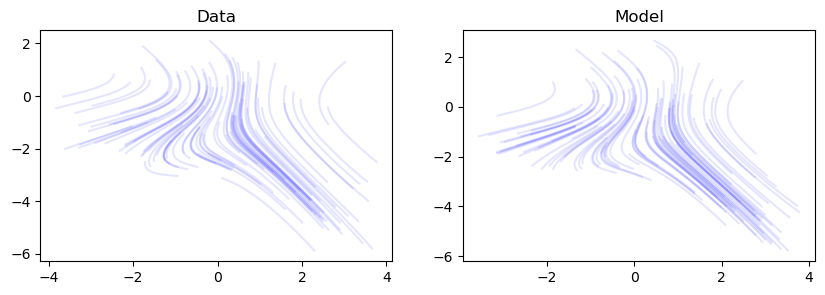

In [268]:
system = system.to(device)
model = model.to(device)

# Sample random initial conditions
X_t = torch.randn(89, 2).to(device)
# Evaluate the model's trajectories
t_span = torch.linspace(0, 90, 90)
_, sys_traj = system(X_t, t_span)
sys_traj = sys_traj.detach().cpu()
traj = traj.detach().cpu()
sys_traj = model.trajectory(X_t, t_span).detach().cpu()
traj = model.trajectory(x0, t_span).detach().cpu()


# Plot the  trajectories with random ICs
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(len(X_t)):
    ax.plot(traj[:,i,0], traj[:,i,1], color='blue', alpha=0.1);
#ax.set_xlim([-3,3])
#ax.set_ylim([-3,3])
#ax.set_xlabel(r"$q$")
#ax.set_ylabel(r"$p$")
ax.set_title("Data")


for i in range(len(X_t)):
    ax2.plot(sys_traj[:,i,0], sys_traj[:,i,1], color='blue', alpha=0.1);
#ax2.set_xlim([-3,3])
#ax2.set_ylim([-3,3])
#ax2.set_xlabel(r"$q$")
#ax2.set_ylabel(r"$p$")
ax2.set_title("Model")